Train CVE terms

In [1]:
import pickle
import numpy as np
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import joblib
from keras.callbacks import Callback
from sklearn.preprocessing import LabelEncoder

class F1ScoreCallback(Callback):
    def __init__(self, X_val, y_val):
        super(F1ScoreCallback, self).__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.best_f1 = 0.0
        self.best_model = None
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        y_val_pred = np.argmax(self.model.predict(self.X_val), axis=1)
        f1 = f1_score(self.y_val, y_val_pred, average='weighted')
        self.f1_scores.append(f1)
        

        if f1 > self.best_f1:
            self.best_f1 = f1
            self.best_model = self.model
            print(f"Epoch {epoch + 1} - F1 Score: {f1:.4f}")
            print("Saved best model")
            print(self.f1_scores)

with open('train_terms.pickle', 'rb') as f1:
    balanced = pickle.load(f1)

with open('test_terms.pickle', 'rb') as f2:
    unbalanced = pickle.load(f2)

train = np.array([item['cve_terms_ada_embedding'] for item in balanced if item['cwe'] != 'None'])
test = np.array([item['cwe'] for item in balanced if item['cwe'] != 'None'])
np.random.seed(42)
X_train, X_val, y_train, y_val = train_test_split(train,test,test_size=0.1,random_state=42)

X_test = np.array([item['cve_terms_ada_embedding'] for item in unbalanced if item['cwe'] != 'None'])
y_test = np.array([item['cwe'] for item in unbalanced if item['cwe'] != 'None'])

label_encoder_train = LabelEncoder()
y_train_encoded = label_encoder_train.fit_transform(y_train)
label_encoder_test = LabelEncoder()
y_test_encoded = label_encoder_test.fit_transform(y_test)


input_dim = X_train.shape[1]
output_dim = len(np.unique(y_train))

model = Sequential()
model.add(Dense(128, input_dim=input_dim, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(output_dim, activation='softmax'))


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

f1_callback = F1ScoreCallback(X_val, label_encoder_train.transform(y_val))

history = model.fit(X_train, y_train_encoded, epochs=40, batch_size=32, validation_data=(X_val, label_encoder_train.transform(y_val)), verbose=1, callbacks=[f1_callback])

best_model = f1_callback.best_model


# Save the best model
joblib.dump(best_model, 'CWE_classes.joblib')

# Make predictions on the test set
y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

y_pred_original = label_encoder_train.inverse_transform(y_pred)

print("Classification Report:\n", classification_report(y_test, y_pred_original, digits=4))

joblib.dump(label_encoder_train, 'label_encoder_train.joblib')

Epoch 1/40
227/227 [==============================] - 1s 2ms/step loss: 1.7366 -
Epoch 1 - F1 Score: 0.6278
Saved best model
[0.6278398031242562]
2036/2036 [==============================] - 9s 4ms/step - loss: 1.7350 - accuracy: 0.5396 - val_loss: 1.2301 - val_accuracy: 0.6604
Epoch 2/40
227/227 [==============================] - 1s 2ms/step loss: 1.1
Epoch 2 - F1 Score: 0.6763
Saved best model
[0.6278398031242562, 0.6762662646196574]
2036/2036 [==============================] - 9s 5ms/step - loss: 1.1516 - accuracy: 0.6761 - val_loss: 1.1045 - val_accuracy: 0.6924
Epoch 3/40
227/227 [==============================] - 1s 2ms/step loss: 1.047
Epoch 3 - F1 Score: 0.6987
Saved best model
[0.6278398031242562, 0.6762662646196574, 0.698728894771814]
2036/2036 [==============================] - 8s 4ms/step - loss: 1.0473 - accuracy: 0.7029 - val_loss: 1.0435 - val_accuracy: 0.7118
Epoch 4/40
227/227 [==============================] - 1s 2ms/step loss: 0.991
Epoch 4 - F1 Score: 0.7003
Saved b

['label_encoder_train.joblib']

Inference CVE terms

In [13]:
import pickle
import numpy as np
from sklearn.metrics import classification_report
import joblib

# Load the saved model
best_model = joblib.load('CWE_classes.joblib')

# Load the label encoder
label_encoder_train = joblib.load('label_encoder_train.joblib')

# Load the test data
with open('test_terms.pickle', 'rb') as f2:
    unbalanced = pickle.load(f2)

X_test = np.array([item['cve_terms_ada_embedding'] for item in unbalanced if item['cwe'] != 'None'])
y_test = np.array([item['cwe'] for item in unbalanced if item['cwe'] != 'None'])

# Make predictions on the test set
y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Convert the predicted labels back to their original form
y_pred_original = label_encoder_train.inverse_transform(y_pred)

# Generate and print the classification report
print("Classification Report:\n", classification_report(y_test, y_pred_original, digits=4))

402/402 [==============================] - 1s 2ms/step
Classification Report:
               precision    recall  f1-score   support

         119     0.8652    0.4561    0.5973      1070
         120     0.4333    0.7959    0.5612       196
         125     0.8422    0.8026    0.8219       532
         134     0.8182    0.9474    0.8780        19
         190     0.7672    0.8900    0.8241       200
          20     0.5549    0.3494    0.4288       810
         200     0.6941    0.5424    0.6089       590
         203     0.5625    0.6667    0.6102        27
          22     0.8545    0.8958    0.8746       518
         269     0.4364    0.4528    0.4444       106
         276     0.3023    0.4062    0.3467        64
         287     0.4763    0.7404    0.5797       285
         295     0.6591    0.7160    0.6864        81
         306     0.5357    0.3191    0.4000        94
         312     0.3846    0.2381    0.2941        42
         319     0.5000    0.5882    0.5405        51
  

Confusion matrix CVE terms

['119', '120', '125', '134', '190', '20', '200', '203', '22', '269', '276', '287', '295', '306', '312', '319', '326', '327', '345', '347', '352', '362', '400', '401', '415', '416', '426', '427', '434', '476', '502', '522', '532', '59', '601', '611', '617', '639', '668', '732', '74', '755', '77', '770', '772', '78', '787', '79', '798', '835', '843', '862', '863', '89', '908', '918', '94', 'accuracy']
              precision    recall  f1-score   support

         119     0.8652    0.4561    0.5973      1070
         120     0.4333    0.7959    0.5612       196
         125     0.8422    0.8026    0.8219       532
         134     0.8182    0.9474    0.8780        19
         190     0.7672    0.8900    0.8241       200
          20     0.5549    0.3494    0.4288       810
         200     0.6941    0.5424    0.6089       590
         203     0.5625    0.6667    0.6102        27
          22     0.8545    0.8958    0.8746       518
         269     0.4364    0.4528    0.4444       106
  

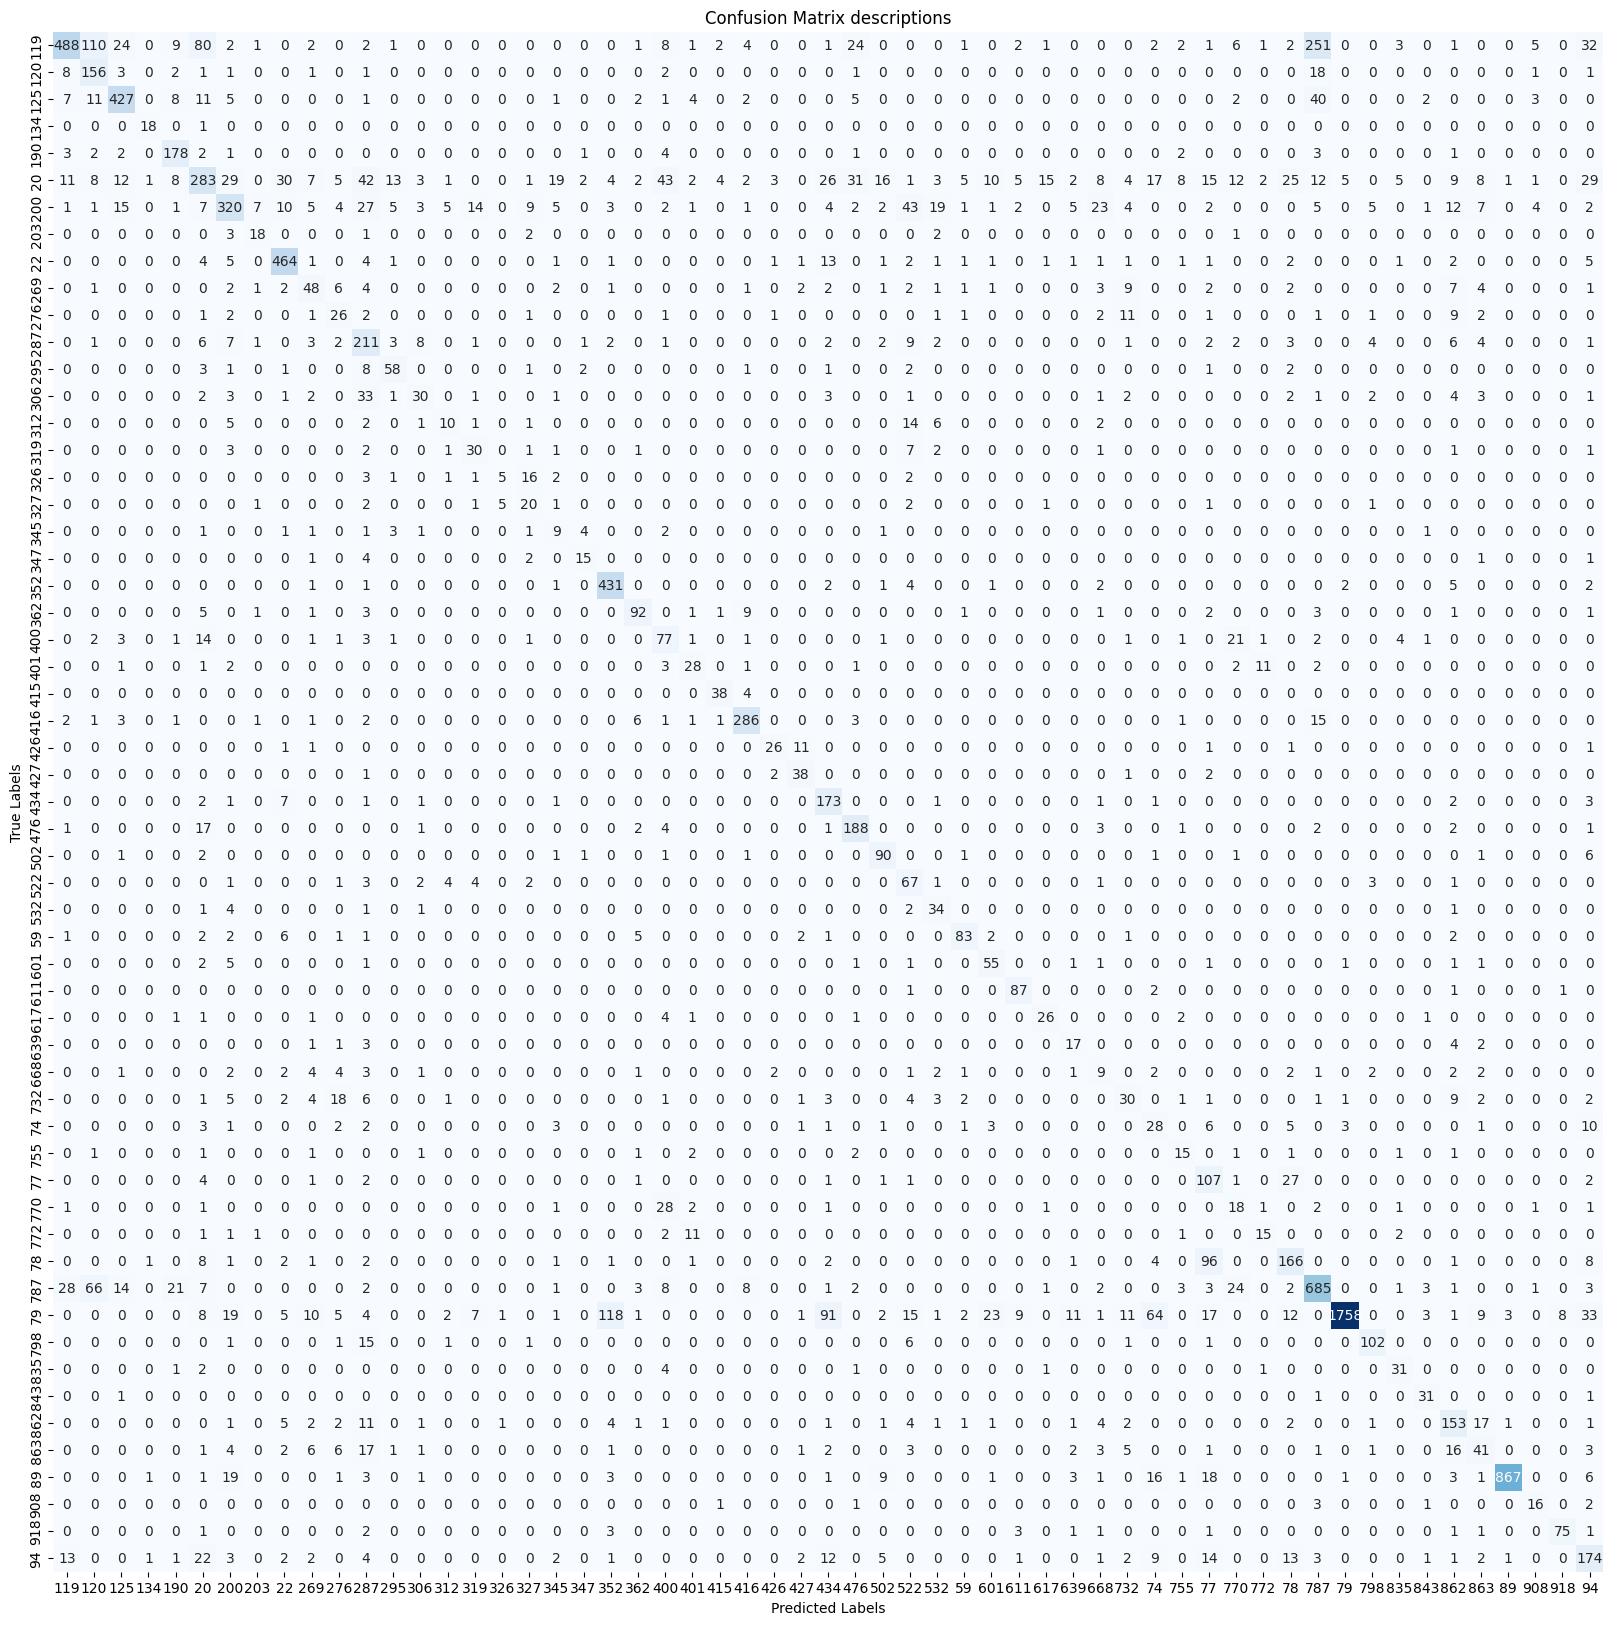

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import classification_report
report= classification_report(y_test, y_pred_original, digits=4)
report_lines = report.split('\n')

# Extract labels from the second line onwards
labels = []
for line in report_lines[2:-3]:
    parts = line.split()
    if len(parts) > 0:
        labels.append(parts[0])

print(labels)
labels.pop(-1)
# Generate classification report
report = classification_report(y_test, y_pred_original, digits=4)
print(report)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_original)

# Plot confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix descriptions")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

Train CVE terms and classify CWE classes

In [1]:
import pickle
import numpy as np
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import joblib
from keras.callbacks import Callback
from sklearn.preprocessing import LabelEncoder

class F1ScoreCallback(Callback):
    def __init__(self, X_val, y_val):
        super(F1ScoreCallback, self).__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.best_f1 = 0.0
        self.best_model = None
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        y_val_pred = np.argmax(self.model.predict(self.X_val), axis=1)
        f1 = f1_score(self.y_val, y_val_pred, average='weighted')
        self.f1_scores.append(f1)
        

        if f1 > self.best_f1:
            self.best_f1 = f1
            self.best_model = self.model
            print(f"Epoch {epoch + 1} - F1 Score: {f1:.4f}")
            print("Saved best model")
            print(self.f1_scores)

with open('train_terms.pickle', 'rb') as f1:
    balanced = pickle.load(f1)

with open('test_terms.pickle', 'rb') as f2:
    unbalanced = pickle.load(f2)

train = np.array([item['cve_terms_ada_embedding'] for item in balanced if item['cwe_class'] != 'None'])
test = np.array([item['cwe_class'] for item in balanced if item['cwe_class'] != 'None'])
np.random.seed(42)
X_train, X_val, y_train, y_val = train_test_split(train,test,test_size=0.1,random_state=42)

X_test = np.array([item['cve_terms_ada_embedding'] for item in unbalanced if item['cwe_class'] != 'None'])
y_test = np.array([item['cwe_class'] for item in unbalanced if item['cwe_class'] != 'None'])

label_encoder_train = LabelEncoder()
y_train_encoded = label_encoder_train.fit_transform(y_train)
label_encoder_test = LabelEncoder()
y_test_encoded = label_encoder_test.fit_transform(y_test)


input_dim = X_train.shape[1]
output_dim = len(np.unique(y_train))

model = Sequential()
model.add(Dense(128, input_dim=input_dim, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(output_dim, activation='softmax'))


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

f1_callback = F1ScoreCallback(X_val, label_encoder_train.transform(y_val))

history = model.fit(X_train, y_train_encoded, epochs=40, batch_size=32, validation_data=(X_val, label_encoder_train.transform(y_val)), verbose=1, callbacks=[f1_callback])

best_model = f1_callback.best_model


# Save the best model
joblib.dump(best_model, 'CWE_classes_class.joblib')

# Make predictions on the test set
y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

y_pred_original = label_encoder_train.inverse_transform(y_pred)

print("Classification Report:\n", classification_report(y_test, y_pred_original, digits=4))

joblib.dump(label_encoder_train, 'label_encoder_train_class.joblib')

Epoch 1/40
227/227 [==============================] - 0s 2ms/step loss: 1.1489 - acc
Epoch 1 - F1 Score: 0.7459
Saved best model
[0.745929560145294]
2036/2036 [==============================] - 7s 3ms/step - loss: 1.1486 - accuracy: 0.6838 - val_loss: 0.8426 - val_accuracy: 0.7633
Epoch 2/40
227/227 [==============================] - 0s 1ms/step loss: 0.7800 - ac
Epoch 2 - F1 Score: 0.7754
Saved best model
[0.745929560145294, 0.775446753333955]
2036/2036 [==============================] - 5s 3ms/step - loss: 0.7800 - accuracy: 0.7818 - val_loss: 0.7688 - val_accuracy: 0.7857
Epoch 3/40
227/227 [==============================] - 0s 1ms/step loss: 0.7138 - ac
Epoch 3 - F1 Score: 0.7955
Saved best model
[0.745929560145294, 0.775446753333955, 0.7955019779361765]
2036/2036 [==============================] - 6s 3ms/step - loss: 0.7136 - accuracy: 0.7993 - val_loss: 0.7193 - val_accuracy: 0.8006
Epoch 4/40
227/227 [==============================] - 0s 1ms/step loss: 0.6755 - ac
Epoch 4 - F1 S

['label_encoder_train_class.joblib']

Inference CVE terms and classify CWE classes

In [5]:
import pickle
import numpy as np
from sklearn.metrics import classification_report
import joblib

# Load the saved model
best_model = joblib.load('CWE_classes_class.joblib')

# Load the label encoder
label_encoder_train = joblib.load('label_encoder_train_class.joblib')

# Load the test data
with open('test_terms.pickle', 'rb') as f2:
    unbalanced = pickle.load(f2)

X_test = np.array([item['cve_terms_ada_embedding'] for item in unbalanced if item['cwe_class'] != 'None'])
y_test = np.array([item['cwe_class'] for item in unbalanced if item['cwe_class'] != 'None'])

# Make predictions on the test set
y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Convert the predicted labels back to their original form
y_pred_original = label_encoder_train.inverse_transform(y_pred)

# Generate and print the classification report
print("Classification Report:\n", classification_report(y_test, y_pred_original, digits=4))


402/402 [==============================] - 1s 1ms/step
Classification Report:
               precision    recall  f1-score   support

         119     0.9082    0.8873    0.8976      2688
          20     0.5583    0.3370    0.4203       810
         200     0.6959    0.6233    0.6576       661
         269     0.4624    0.4057    0.4322       106
         287     0.6783    0.7703    0.7214       679
         311     0.5000    0.4032    0.4464       124
         327     0.3529    0.5143    0.4186        35
         345     0.7302    0.9145    0.8120       503
         362     0.6410    0.8197    0.7194       122
         400     0.5469    0.6802    0.6063       197
         404     0.7053    0.7791    0.7403        86
         610     0.6233    0.8893    0.7329       253
         665     0.6667    0.5833    0.6222        24
         668     0.6226    0.6600    0.6408       150
         669     0.6109    0.8660    0.7164       194
         670     0.5455    0.6316    0.5854        38
  

Confusion matrix CVE terms and classify CWE classes

['119', '20', '200', '269', '287', '311', '327', '345', '362', '400', '404', '610', '665', '668', '669', '670', '672', '682', '704', '706', '732', '74', '754', '755', '834', '862', '863', '913', 'accuracy']
              precision    recall  f1-score   support

         119     0.9082    0.8873    0.8976      2688
          20     0.5583    0.3370    0.4203       810
         200     0.6959    0.6233    0.6576       661
         269     0.4624    0.4057    0.4322       106
         287     0.6783    0.7703    0.7214       679
         311     0.5000    0.4032    0.4464       124
         327     0.3529    0.5143    0.4186        35
         345     0.7302    0.9145    0.8120       503
         362     0.6410    0.8197    0.7194       122
         400     0.5469    0.6802    0.6063       197
         404     0.7053    0.7791    0.7403        86
         610     0.6233    0.8893    0.7329       253
         665     0.6667    0.5833    0.6222        24
         668     0.6226    0.6600   

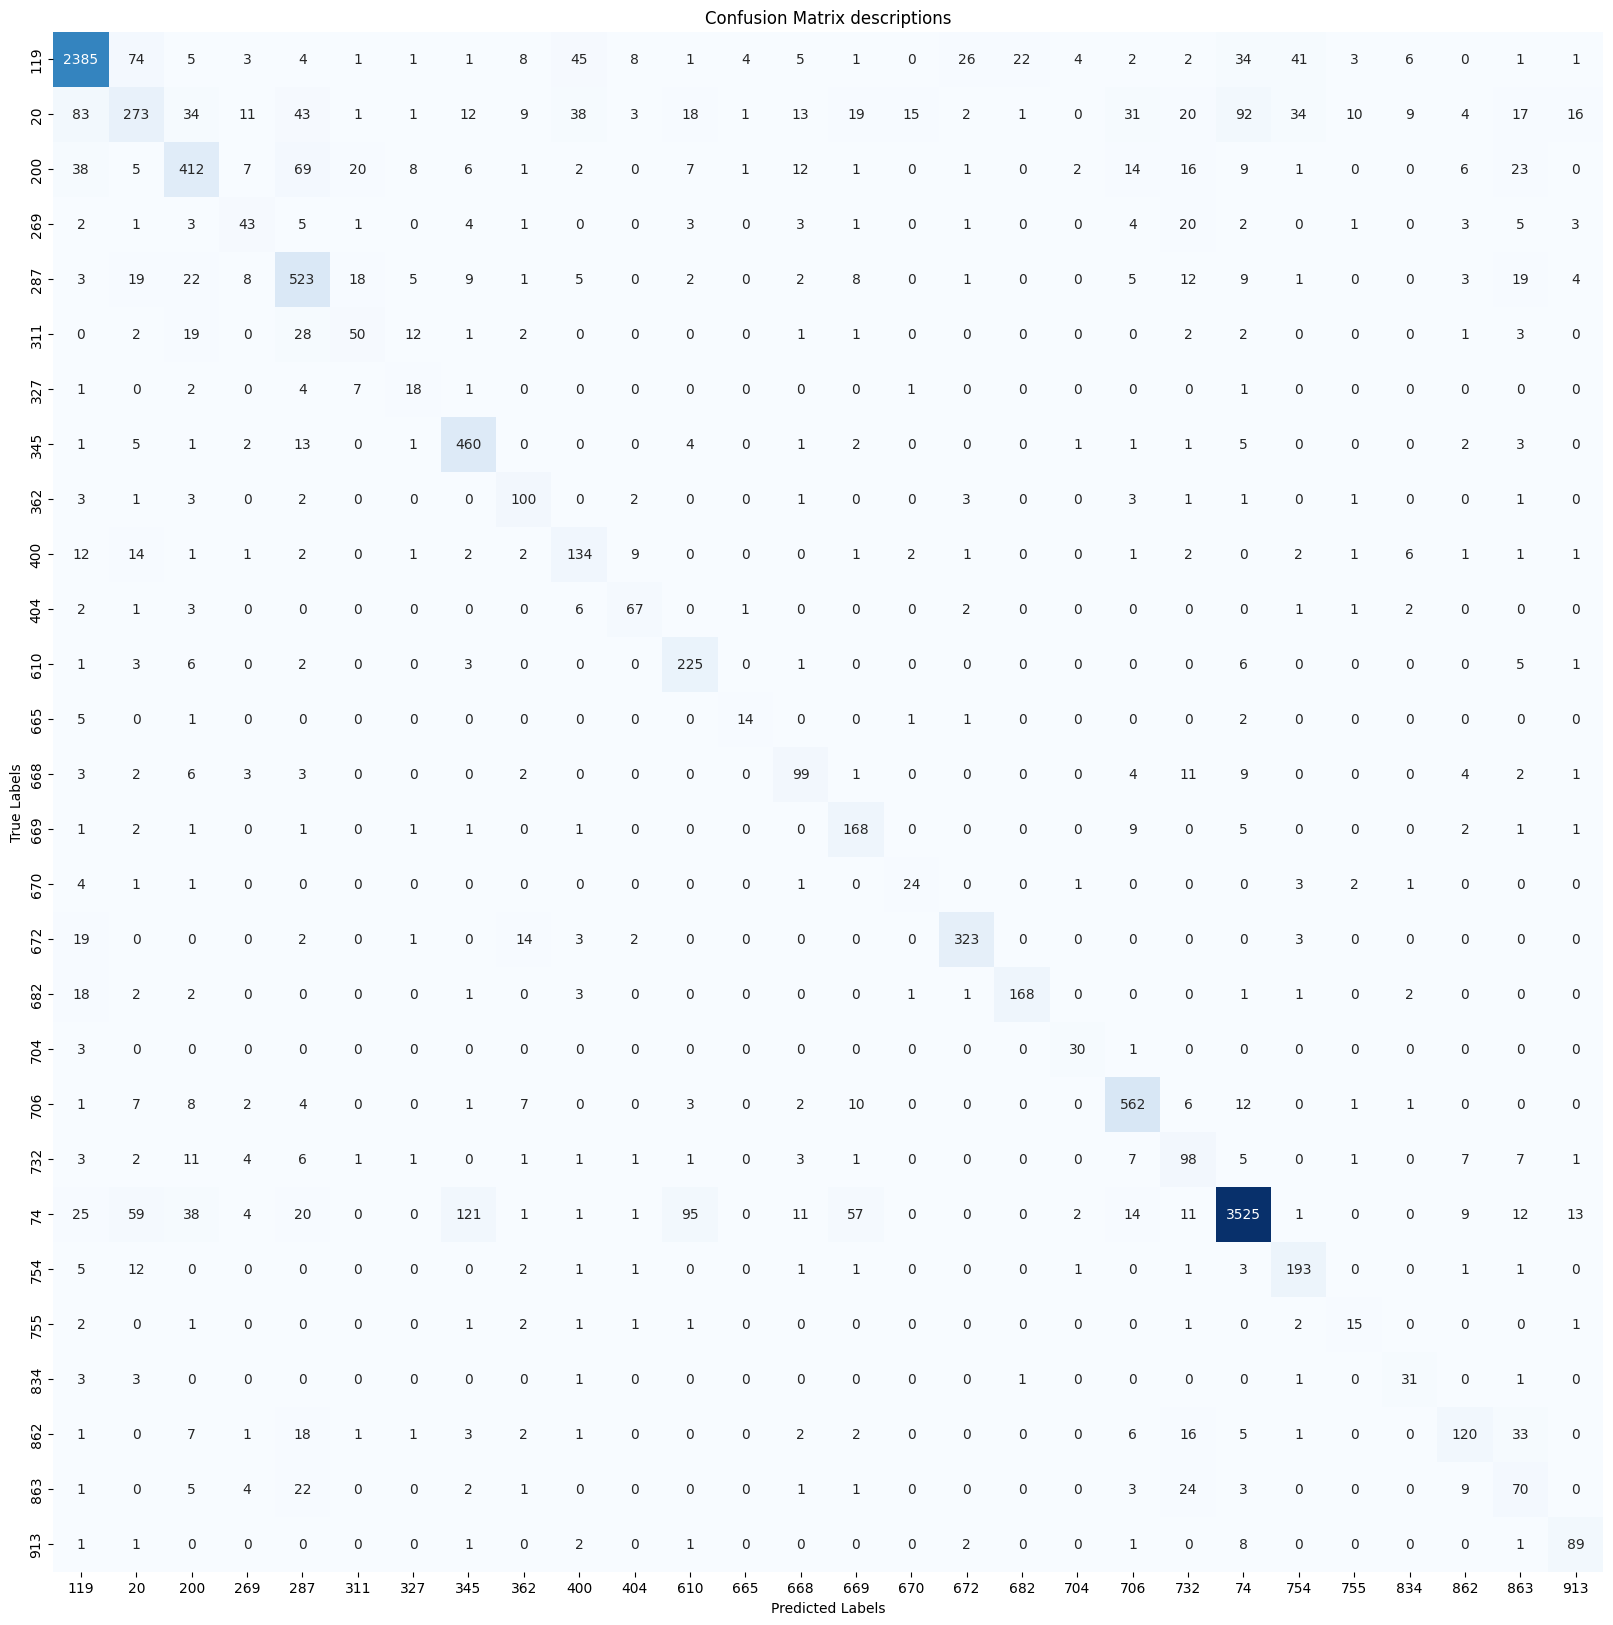

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import classification_report
report= classification_report(y_test, y_pred_original, digits=4)
report_lines = report.split('\n')

# Extract labels from the second line onwards
labels = []
for line in report_lines[2:-3]:
    parts = line.split()
    if len(parts) > 0:
        labels.append(parts[0])

print(labels)
labels.pop(-1)
# Generate classification report
report = classification_report(y_test, y_pred_original, digits=4)
print(report)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_original)

# Plot confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix descriptions")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()